In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import seaborn as sns

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 15
END_YEAR = 2015

### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

In [8]:
start_time = timeit.default_timer()
print(start_time)

3119979.318424265


### Read Gender details

In [9]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')
print(gender.shape)
gender = gender.drop_duplicates()
print(gender.shape)
# Gender file is full of duplicates. As we use the author's name as ID, duplicate entries provide no extra info
gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender.groupby('gender').size())

(1704919, 2)
(1704919, 2)
          author gender
0   gareth beale      m
1    graeme earl      m
2  altaf hossain      m
3   faisal zaman      m
4      m. nasser   none
['m' 'none' 'f']
gender
f       255793
m       796975
none    652151
dtype: int64


### Read authors with start and end year details

In [10]:
# Different files exists depending upon their career length

#authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

print("author unique names  - ", authorStartEndCareerData['author'].nunique())
authorStartEndCareerData.head()

authorStartEndCareerData before filtering -  129022
authorStartEndCareerData after filtering -  129022
author unique names  -  129022


,author,start_year,end_year,num_pub,career_length
0,'maseka lesaoana,2001,2015,2,15
1,a min tjoa,1979,2017,191,39
2,a-imam al-sammak,1992,2006,3,15
3,a-xing zhu,1998,2017,22,20
4,a. a. (louis) beex,1980,2016,31,37


### Merge credible authors and their gender information

In [11]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')

# print("authorStartEndCareerData with duplicates: ", authorStartEndCareerData.shape[0])
# authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: ", authorStartEndCareerData.shape[0])

authorStartEndCareerData.head()

authorStartEndCareerData no duplicates:  129022


,author,start_year,end_year,num_pub,career_length,gender
0,'maseka lesaoana,2001,2015,2,15,none
1,a min tjoa,1979,2017,191,39,none
2,a-imam al-sammak,1992,2006,3,15,m
3,a-xing zhu,1998,2017,22,20,none
4,a. a. (louis) beex,1980,2016,31,37,m


### Read Citation data (uses author->author network)

In [14]:
authorCitationsData = pd.read_csv('data/authors_cited_by_authors_2017_asiansAsNone_by_daniel.txt')
# Using file made by daniel

#id1 represents the author who cited
#id2 is the author who has been cited by id1 in year Y
authorCitationsData.rename(columns={'author_cited':'author', 'year_cit':'year'}, inplace=True)

print('authorCitationsData before filtering - ',authorCitationsData.shape[0])
authorCitationsData = authorCitationsData[authorCitationsData["year"] >= 1970]
print('authorCitationsData after filtering - ',authorCitationsData.shape[0])

#Group by both year and author - multi index and hierarchial indexing
authorCitationsData = authorCitationsData.groupby(['year','author']).count().reset_index()
authorCitationsData.rename(columns={'author_citing':'num_cit'}, inplace=True)
print(authorCitationsData.head())

print('authorCitationsData after grouping - ',authorCitationsData.shape)

authorCitationsData[authorCitationsData.author == "stefano rizzi"].head()

##remove wrong data
#authorCitationsData = authorCitationsData[authorCitationsData["year"] > 1900]
#print(authorCitationsData[authorCitationsData.author=="a min tjoa"])

authorCitationsData before filtering -  258491953
authorCitationsData after filtering -  258474147
   year          author  num_cit
0  1970     a. a. afifi        3
1  1970   a. b. carroll        3
2  1970   a. bensoussan        7
3  1970  a. c. mckellar        1
4  1970   a. d. wallace        2
authorCitationsData after grouping -  (7027728, 3)


,year,author,num_cit
254661,1993,stefano rizzi,2
351709,1995,stefano rizzi,12
410791,1996,stefano rizzi,19
478518,1997,stefano rizzi,7
554168,1998,stefano rizzi,18


### Merge Citations with credible authors and their gender information

In [15]:
authorCitationsData = pd.merge(authorCitationsData, authorStartEndCareerData,  
                                          how="left", left_on="author", right_on="author")
print("authorCitationsData before filtering: %s", authorCitationsData.shape[0])
authorCitationsData = authorCitationsData.dropna(how='any')
print("authorCitationsData after filtering: %s", authorCitationsData.shape[0])

authorCitationsData before filtering: %s 7027728
authorCitationsData after filtering: %s 1956599


In [16]:
authorCitationsData.head()

,year,author,num_cit,start_year,end_year,num_pub,career_length,gender
40,1970,alfonso f. cardenas,2,1970.0,2011.0,48.0,42.0,m
81,1970,b. f. caviness,2,1970.0,1986.0,13.0,17.0,m
87,1970,ben wegbreit,9,1970.0,2011.0,30.0,42.0,none
216,1970,david pager,1,1970.0,2011.0,13.0,42.0,none
218,1970,david r. olsen,2,1970.0,2005.0,6.0,36.0,none


126191
     year               author  num_cit  start_year  end_year  num_pub  \
40   1970  alfonso f. cardenas        2      1970.0    2011.0     48.0   
81   1970       b. f. caviness        2      1970.0    1986.0     13.0   
87   1970         ben wegbreit        9      1970.0    2011.0     30.0   
216  1970          david pager        1      1970.0    2011.0     13.0   
218  1970       david r. olsen        2      1970.0    2005.0      6.0   

     career_length gender  
40            42.0      m  
81            17.0      m  
87            42.0   none  
216           42.0   none  
218           36.0   none  


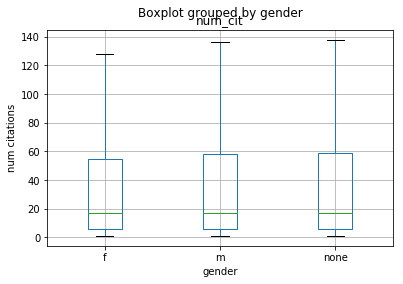

In [17]:
#print(authorCitationsData.head(n=2))
print(authorCitationsData['author'].nunique())
#print(authorCitationsData.shape[0])

print(authorCitationsData.head())
#print(authorCitationsData[authorCitationsData.author=="stefano rizzi"])


ax = authorCitationsData.boxplot(column='num_cit', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

### There are some differences between publication and citation data which is collected by DBLP and Aminer 
#### Data found for authors whose work were cited in the years which are lesser than their starting year of publishing. For our analysis these data are removed. Whereas author's work will be cited even after he/she ends their career

In [18]:
authorCitationsData.head()

,year,author,num_cit,start_year,end_year,num_pub,career_length,gender
40,1970,alfonso f. cardenas,2,1970.0,2011.0,48.0,42.0,m
81,1970,b. f. caviness,2,1970.0,1986.0,13.0,17.0,m
87,1970,ben wegbreit,9,1970.0,2011.0,30.0,42.0,none
216,1970,david pager,1,1970.0,2011.0,13.0,42.0,none
218,1970,david r. olsen,2,1970.0,2005.0,6.0,36.0,none


In [19]:
print('authorCitationsData before filtering', authorCitationsData.shape[0])
temp =  authorCitationsData[authorCitationsData['year'] < authorCitationsData['start_year']]
print(temp.shape[0],' rows were present')

authorCitationsData = authorCitationsData[authorCitationsData['year'] >= authorCitationsData['start_year']]
authorCitationsData = authorCitationsData.reset_index(drop = True)

print('authorCitationsData after filtering', authorCitationsData.shape[0])
authorCitationsData.head()

authorCitationsData before filtering 1956599
0  rows were present
authorCitationsData after filtering 1956599


,year,author,num_cit,start_year,end_year,num_pub,career_length,gender
0,1970,alfonso f. cardenas,2,1970.0,2011.0,48.0,42.0,m
1,1970,b. f. caviness,2,1970.0,1986.0,13.0,17.0,m
2,1970,ben wegbreit,9,1970.0,2011.0,30.0,42.0,none
3,1970,david pager,1,1970.0,2011.0,13.0,42.0,none
4,1970,david r. olsen,2,1970.0,2005.0,6.0,36.0,none


### Test Data

In [20]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

        year            author  num_cit  start_year  end_year  num_pub  \
48312   1988  donatella sciuto        2      1987.0    2016.0    349.0   
58542   1989  donatella sciuto        1      1987.0    2016.0    349.0   
70836   1990  donatella sciuto        2      1987.0    2016.0    349.0   
85198   1991  donatella sciuto        4      1987.0    2016.0    349.0   
102206  1992  donatella sciuto       13      1987.0    2016.0    349.0   
121829  1993  donatella sciuto       30      1987.0    2016.0    349.0   
144674  1994  donatella sciuto       39      1987.0    2016.0    349.0   
171066  1995  donatella sciuto       62      1987.0    2016.0    349.0   
201144  1996  donatella sciuto       63      1987.0    2016.0    349.0   
235192  1997  donatella sciuto      154      1987.0    2016.0    349.0   

        career_length gender  
48312            30.0      f  
58542            30.0      f  
70836            30.0      f  
85198            30.0      f  
102206           30.0      f  

# Cohort Analysis on all authors for 15 years

#### Select Cohorts based on Start Years

In [21]:
years = authorCitationsData['year'].unique()
years = sorted(years)
print(years)


cohort_start_years = [y for y in years if y < (END_YEAR - CAREER_LENGTH)]
#cohort_start_years = [1974, 1984, 1994]

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


### Cohort Analysis (Num Cit)

   year               author  num_cit  start_year  end_year  num_pub  \
0  1970  alfonso f. cardenas        2      1970.0    2011.0     48.0   
1  1970       b. f. caviness        2      1970.0    1986.0     13.0   
2  1970         ben wegbreit        9      1970.0    2011.0     30.0   

   career_length gender  
0           42.0      m  
1           17.0      m  
2           42.0   none  


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/danielkostic/anaconda3/li

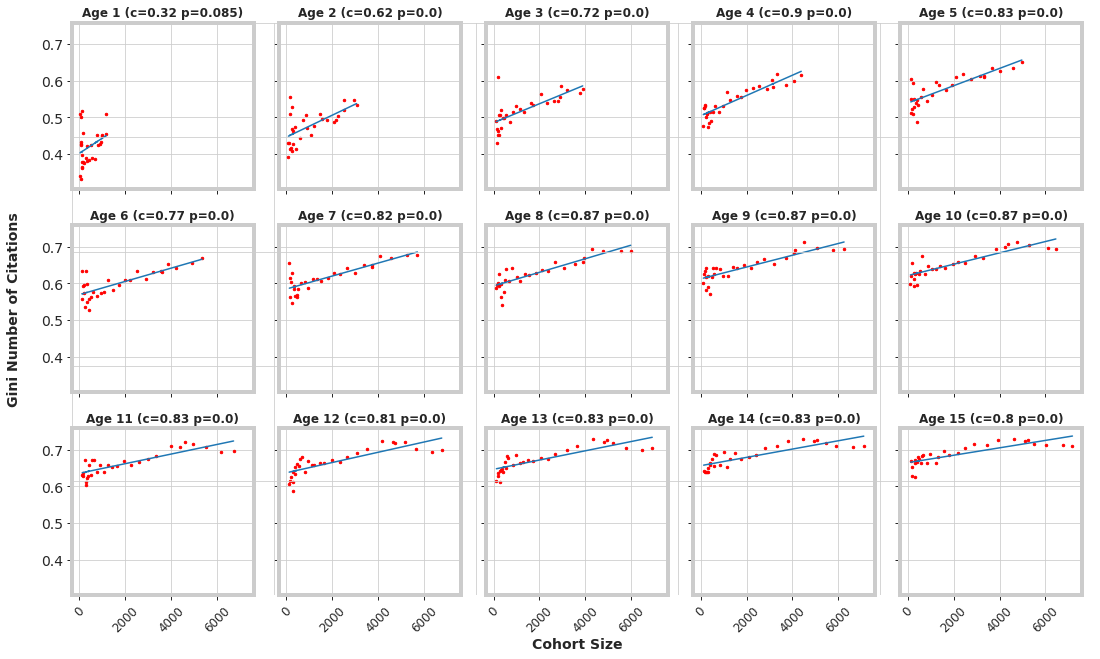

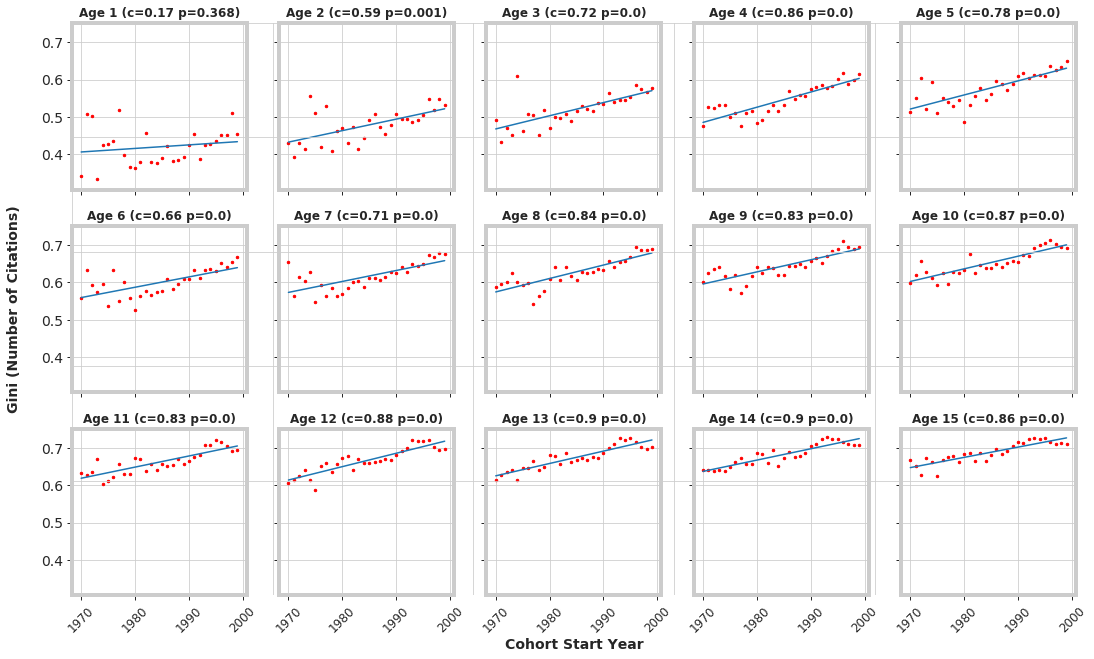

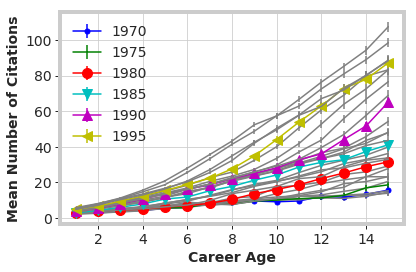

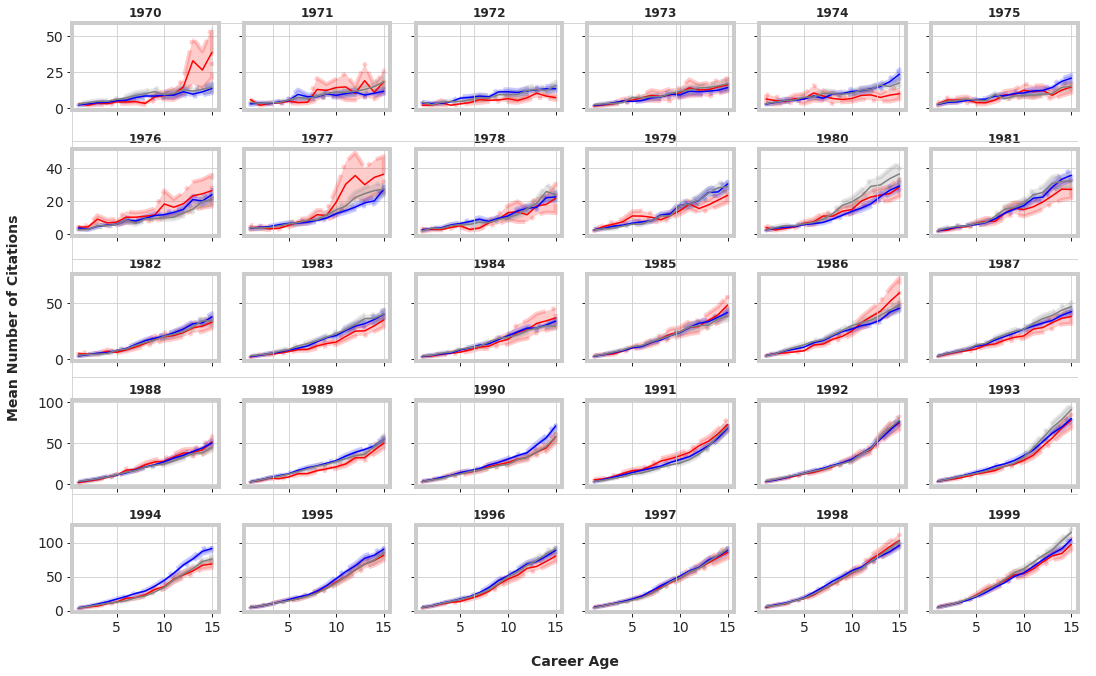

In [22]:
#print(plt.style.available)
from importlib import reload

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', cohort_start_years, CAREER_LENGTH, 'Citations Count')

plot.run_cohort_analysis(authorCitationsData, cohort_start_years, CAREER_LENGTH, "num_cit", "Number of Citations")  


### Cohort Analysis (Cum Num Cit)

In [23]:
plot.run_cohort_analysis(authorCitationsData, cohort_start_years, 
                         CAREER_LENGTH, "cum_num_cit", "Cumulative Number of Citations")  

   year               author  num_cit  start_year  end_year  num_pub  \
0  1970  alfonso f. cardenas        2      1970.0    2011.0     48.0   
1  1970       b. f. caviness        2      1970.0    1986.0     13.0   
2  1970         ben wegbreit        9      1970.0    2011.0     30.0   

   career_length gender  
0           42.0      m  
1           17.0      m  
2           42.0   none  


KeyError: "['cum_num_cit'] not in index"

### Cumulative Distributions for Selected Cohorts and Career Ages

how do these distributions differ?

In [ ]:
cohort_start_years = [1970, 1974, 1984, 1994, 1998]

cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'num_cit')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_cit', 'Number of Citations')

cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'cum_num_cit')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'cum_num_cit', 'Cumulative Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'cum_num_cit', 'Cumulative Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 10, 'cum_num_cit', 'Cumulative Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 15, 'cum_num_cit', 'Cumulative Number of Citations')

### Why is there a sudden increase in mean citation count for cohort started in 1985?

In [ ]:
_1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1985] 
_1985Authors.shape

In [ ]:
_1985Authors.columns

In [ ]:
# _1985Authors.sort_values(by=['num_cit'], axis = 0, ascending=False,inplace=False)

In [ ]:
_1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
_1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
print(_1995_2000_year_1985Authors.shape)
_1995_2000_year_1985Authors.head(10)

In [ ]:
temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
temp.head()

#print(temp1['id2'].unique())

In [ ]:
donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
donatella

In [ ]:
plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [ ]:
# authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

In [ ]:
#just for debugging
reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

In [ ]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)